# AMPSphere v.2022-03

This is a notebook meant to form the set of notebooks used to analyze the data in AMPSphere and write the manuscript:

__AMPSphere: Global survey of prokaryotic antimicrobial peptides shaping microbiomes__

### Testing Heap's Law for c_AMPs from high-quality microbial genomes (ProGenomes2)

We tested the adjustment of rarefaction curves of c_AMPs from high-quality microbial genomes to the Heap's Law, which states: 

n = k*N<sup>Y</sup>, Where:

- n represents the number of newly added c_AMPs to the pan-genome,
- N is the number of sampled genomes, and
- k and Y represent fitting parameters.

If Y > 0 it is verified that the pan-genome is open and new genomes tend to add more and more c_AMPs to the pan-genome, instead of estabilizing. To more details of how this work, please refer to this [link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6491781/pdf/fmicb-10-00834.pdf)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from itertools import chain
from collections import Counter

In [2]:
def heapslaw(t):
    from scipy.optimize import curve_fit
    from sklearn.metrics import r2_score
    
    t = pd.DataFrame(t, columns=['genomes', 'amps'])
    
    def func_powerlaw(x, k, a):
        return k*(x**a)
    
    target_func = func_powerlaw
    
    popt, pcov = curve_fit(target_func, t['genomes'], t['amps'])
    
    t['pred'] = [func_powerlaw(x, popt[0], popt[1]) for x in t['genomes']]
    
    r2 = r2_score(t['amps'], t['pred'])
    
    return popt, r2

In [3]:
def countclasses(df, sp: str, rep=None, step=None, verbose=False) -> tuple:
    spdf = df[df.source == sp]['amp']
    spdf = spdf.apply(lambda x: list(x))
    L = len(spdf)
    if rep == None: rep = 32
    if (step == None) and (L < 50): step = 1
    elif (step == None) and (L < 100): step = 5
    elif (step == None) and (L >= 100): step = 10
    t = []
    for n in range(L, 0, -step):
        if n != L:
            k = 0
            for _ in range(rep):
                freqs = Counter(chain.from_iterable(spdf.sample(n)))
                k += len(freqs)
            t.append([n, k/rep])
    popt, r2 = heapslaw(t)
    if verbose:
        print(sp, L, rep, popt[0], popt[1], r2, t)
        return (sp, L, rep, popt[0], popt[1], r2, t)
    else:
        return (sp, L, rep, popt[0], popt[1], r2)

In [4]:
# load c_AMPs
refdata = pd.read_table('data/gmsc_amp_genes_envohr_source.tsv.gz',
                        sep='\t',
                        header='infer')
refdata = refdata[refdata.is_metagenomic == False]
refdata = refdata[~(refdata.specI.isna())]
refdata = refdata[['amp','sample','specI']]
refdata = refdata.groupby(['specI', 'sample'])['amp'].apply(lambda x: set(x)).reset_index()
refdata.rename({'specI': 'source'}, axis=1, inplace=True)

We then calculate the number of samples without c_AMPs we need to add to each species cluster.

In [5]:
# calculate the size of species clusters
df = pd.read_table('data/pgenomes_samples.tsv.gz',
                       sep='\t',
                       header=None,
                       names=['specI', 'genome'])
df = df.specI.value_counts()
df = df[df >= 10]

# refdata cluster size
rdf = refdata.source.value_counts()
rdf = pd.concat([rdf, df], axis=1)
rdf = rdf.dropna()
rdf['replicate'] = rdf.specI - rdf.source

In [6]:
# adding mock samples without c_AMPs
rdf.replicate = rdf.replicate.astype('int')

for spec, _, _, replicate in rdf.itertuples():
    itdf = pd.DataFrame([[spec, 'mocksample', {}]], columns=['source', 'sample', 'amp'])
    itdf = itdf.sample(replicate, replace=True)
    refdata = pd.concat([refdata, itdf])

refdata

,source,sample,amp
0,specI_v3_Cluster10,1423959.SAMN05444407,{AMP10.824_320}
1,specI_v3_Cluster100,1218085.SAMD00019864,{AMP10.631_886}
2,specI_v3_Cluster100,637910.SAMEA2272524,{AMP10.631_886}
3,specI_v3_Cluster10002,1805714.SAMEA4475147,{AMP10.235_570}
4,specI_v3_Cluster1001,1262900.PRJEB972,"{AMP10.043_582, AMP10.360_141}"
...,...,...,...
0,specI_v3_Cluster3117,mocksample,{}
0,specI_v3_Cluster3117,mocksample,{}
0,specI_v3_Cluster3117,mocksample,{}
0,specI_v3_Cluster3117,mocksample,{}


In [7]:
k = refdata.source.value_counts()
k = k[k >= 10].index

splist = []
for sp in k:
    t = countclasses(refdata, sp)
    splist.append(t)

In [8]:
splist = pd.DataFrame(splist,
                      columns=['species',
                               'samples',
                               'replicates',
                               'k',
                               'alpha',
                               'r2'])

splist

splist.to_csv('specI_heapslaw.tsv.gz', sep='\t', header=True, index=None)

Text(0, 0.5, 'Counts')

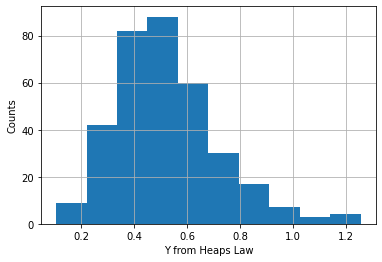

In [11]:
splist[splist.r2 > 0.9].alpha.hist()

plt.xlabel('Y from Heaps Law')
plt.ylabel('Counts')

In [12]:
splist

,species,samples,replicates,k,alpha,r2
0,specI_v3_Cluster340,7867,32,1.352070,0.399792,0.997381
1,specI_v3_Cluster282,7284,32,2.895016,0.363066,0.991981
2,specI_v3_Cluster99,6840,32,8.563098,0.315094,0.984169
3,specI_v3_Cluster884,5243,32,0.765203,0.389583,0.965668
4,specI_v3_Cluster95,4463,32,6.038520,0.453209,0.996382
...,...,...,...,...,...,...
390,specI_v3_Cluster3276,10,32,0.341071,0.510793,0.952207
391,specI_v3_Cluster4354,10,32,2.283138,0.433016,0.994491
392,specI_v3_Cluster4794,10,32,0.746119,0.831029,0.990493
393,specI_v3_Cluster4535,10,32,0.429756,0.820001,0.970006
